In [22]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import numpy as np 
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image

<h2>
    <center>
        General Ramsey Spectroscopy
    </center>
</h2>

Suppose that we have a pulse with turn-on time much faster than the time scale of the system. According to [Wikipedia](https://en.wikipedia.org/wiki/Bloch_sphere) a rotation about the $y$-axis of the Bloch sphere can be written as

$$
R_x(\theta) = \cos(\theta/2) \mathbb{I} - i \sin(\theta/2) \sigma_x
$$

where $\theta$ is the rotation angle of the qubit state, $\mathbb{I}$ is the identity operator, and $\sigma_x = \sigma + \sigma^\dagger$. 

In [171]:
class N_dipole_system:
    def __init__(self, N):
        # Number of atoms 
        self.N = N

        ### annihilation operators ###
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # |1><0| for an Ns-state system

        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))

        
        ### initial states ###
        self.ket_excited = tensor([basis(2,1) for _ in range(self.N)])  #ket( [1]*N, dim = [2] * N)
        self.ket_ground = tensor([basis(2,0) for _ in range(self.N)])  #ket( [0]*N, dim = [2] * N)

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

        # list of states
        self.states = []
        self.H = []

    
    def Rx(self, theta):
        return np.cos(theta/2)*self.id_tot - 1j*np.sin(theta/2)*self.sx_tot
    
    def pulse(self, theta, N):
        rx = lambda theta : np.cos(theta/2)*qeye(2) - 1j*np.sin(theta/2)*sigmax()

        thetalist = np.linspace(0, theta, N)
        psi0 = self.states[-1]
        for th in thetalist:
            atoms = [psi0.ptrace(i) for i in range(self.N)]
            atoms = [rx(th) * atom for a, atom in enumerate(atoms)]
            self.states += [tensor(atoms)]

        # atoms = [psi0.ptrace(i) for i in range(self.N)]
        # psi0 = self.states[-1]
        # self.states += [self.Rx(x) * psi0 for x in thetalist]
        return self.states[-1]
    
    def evolve(self, tlist, c_ops=[]):
        psi0 = self.states[-1]
        self.states += mesolve(self.H, psi0, tlist, c_ops=c_ops).states
        return self.states[-1]

    def animate_bloch(self, fname, duration=1, save_all=False):
        b = Bloch()
        b.vector_color = ['r']
        b.view = [-40,30]
        images=[]
        length = len(self.states)
        ## normalize colors to the length of data ##
        nrm = mpl.colors.Normalize(0,length)
        colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

        ## customize sphere properties ##
        b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
        b.point_marker = ['o']
        b.point_size = [30]
        
        for i in range(length):
            b.clear()

            b.add_states([self.states[i].ptrace(j) for j in range(self.N)])
            b.add_states([self.states[j].ptrace(0) for j in range(i+1)],'point')
            if save_all:
                b.save(dirc='tmp') #saving images to tmp directory
                filename="tmp/bloch_%01d.png" % i
            else:
                filename='temp_file.png'
                b.save(filename)
            images.append(imageio.imread(filename))
        imageio.mimsave(fname, images, duration=duration)

<h2>
    <center>
        Two non-interacting atoms with different frequencies
    </center>
</h2>

Suppose that we have two non-interacting atoms with different frequencies. The Hamiltonian of the system is

$$
H = \frac{\hbar \omega_1}{2} \sigma_1^\dagger \sigma_1 + \frac{\hbar \omega_2}{2} \sigma_2^\dagger \sigma_2
$$

where $\omega_1$ and $\omega_2$ are the frequencies of the two atoms. For simplicity, we assume that the decay time is much longer than the time scale of the experiment. 

In [173]:
tlist = np.linspace(0, 10, 10)


sys = N_dipole_system(1)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] #+ sys.sm_list[1].dag() * sys.sm_list[1]
sys.states = [tensor([basis(2,0), basis(2,0)])]
sys.pulse(np.pi/2, 10)
sys.evolve(tlist)
sys.pulse(np.pi/2, 10)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.91952943-0.27201846j 0.        +0.j        ]
 [0.27201846-0.08047057j 0.        +0.j        ]]

In [172]:
tlist = np.linspace(0, 10, 10)


sys = N_dipole_system(1)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] #+ sys.sm_list[1].dag() * sys.sm_list[1]
sys.states = [tensor([basis(2,0), basis(2,0)])]
sys.pulse(np.pi/2, 10)
sys.evolve(tlist)
sys.pulse(np.pi/2, 10)
sys.animate_bloch(fname='non_interacting.gif', duration=2)
Image(filename='non_interacting.gif')

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

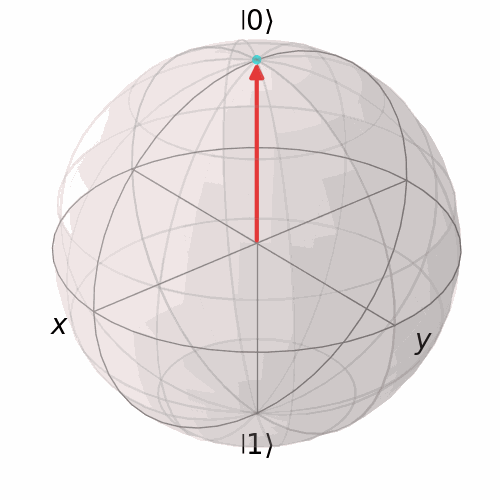

In [30]:
Image(filename='bloch_anim.gif')

Text(0, 0.5, '$\\rho_{ee}$')

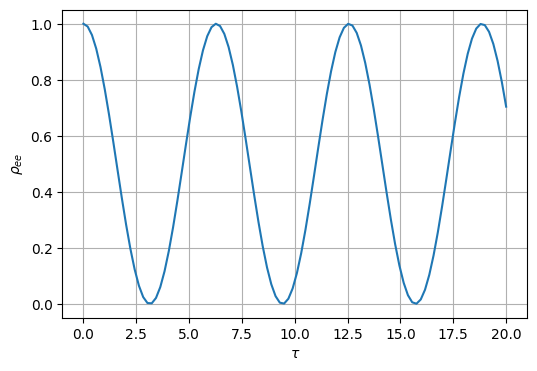

In [16]:
sys = N_dipole_system(2)

omega_0 = 0
omega_1 = 1
H = omega_0 * sys.sm_list[0].dag() * sys.sm_list[0] + omega_1 * sys.sm_list[1].dag() * sys.sm_list[1]

tlist = np.linspace(0, 20, 100)

psi0 = sys.ket_ground
psi0 = sys.Rx(np.pi/2) * psi0
res = mesolve(H, psi0, tlist, c_ops=[])
states = res.states
states = [sys.Rx(np.pi/2) * state for state in states]

excited_state_pop = [expect(sys.sm_tot.dag() * sys.sm_tot, state) for state in states]

plt.figure(figsize=(6,4))
plt.plot(tlist, excited_state_pop)
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')

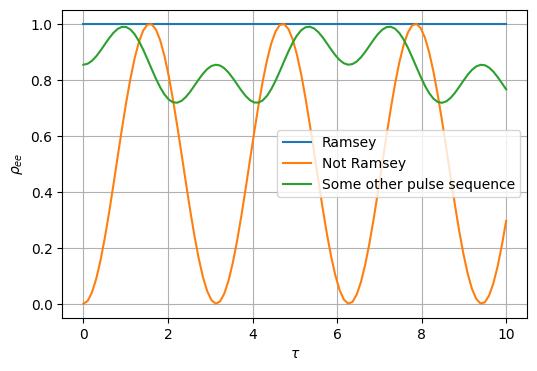

In [ ]:
sys = N_dipole_system(2)

omega_0 = 0
omega_1 = 1
H = omega_0 * sys.sm_list[0].dag() * sys.sm_list[0] + omega_1 * sys.sm_list[1].dag() * sys.sm_list[1]

tlist = np.linspace(0, 10, 100)

def pulse_sequence(t, theta_list):
    psi = sys.ket_ground
    for n, theta in enumerate(theta_list):
        psi = sys.Rx(theta) * psi
        if n != len(theta_list) - 1:
            psi = mesolve(H, psi, [0,t], c_ops=[]).states[-1]
    return expect(sys.sp_tot.dag() * sys.sp_tot, psi)


rho_e_ramsey = [pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [pulse_sequence(t, [np.pi/2, 0, np.pi/2]) for t in tlist]
rho_e_whatever = [pulse_sequence(t, [np.pi/2, np.pi/2, np.pi/2, np.pi/4]) for t in tlist]


plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label='Ramsey')
plt.plot(tlist, rho_e_not_ramsey, label='Not Ramsey')
plt.plot(tlist, rho_e_whatever, label='Some other pulse sequence')
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend()